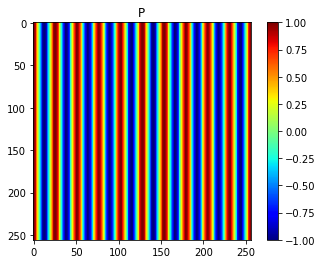

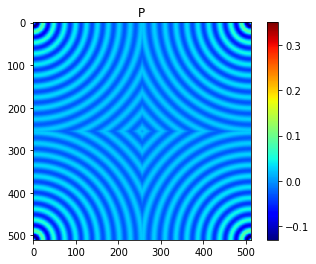

[[ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 ..., 
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]]
out:  (65536, 1)


In [13]:
import matplotlib.pyplot as plt
import numpy as np
import scipy.special


def empty_mask(size):
    return np.zeros((size,size))

def circular_mask(size):
    y,x = np.mgrid[:size, :size]
    M = np.zeros((size,size))
    x0 = y0 = (size-1)/2
    r = size/4
    M[((x-x0)**2<=r**2)*((y-y0)**2<=r**2)]=1
    
    return M
    

def get_greenfun(r,k):
    return (1j/4)*scipy.special.hankel1(0,k*r)
def get_green_matrix(k,size):
    j,i = np.mgrid[:size, :size]
    ij_block = np.sqrt((i-1/2)**2+j**2)
    green_mat = get_greenfun(ij_block,k)
    return green_mat

def get_toeplitz_mat(ij_block):
    T = np.block([[ij_block,ij_block[:,:0:-1]],
                  [ij_block[:0:-1,:],ij_block[:0:-1,:0:-1]]])
    return T
    
def G_matvec(vec,k):
    #print(vec)
    size = int(np.sqrt(vec.shape[0]))
    G_block = get_green_matrix(k,size)
    G = get_toeplitz_mat(G_block)
    mat = np.zeros((2*size-1,2*size-1))
    
    mat_block = vec.reshape((-1,size))
    mat[:size,:size] = mat_block
    out_mat = np.fft.ifft2(np.fft.fft2(G)*np.fft.fft2(mat))
    out = out_mat[:size,:size].reshape((-1,1))
    out = out.real
    print("out: ",out.shape)
    return out
def diag(mask):
    return mask.reshape((-1,size))

def matvec(x,mask,k,e):
    x = x.reshape((-1,1))
    size = x.shape[0]
    eps = (e-1)*mask.reshape((-1,1))+1
    print(eps.reshape(-1,mask.shape[0]))
    chi = k**2*(eps - 1)
    #print(x,diag)
    return x+1/((size-1)**2)*G_matvec(x*chi,k)

def visualize(data,title = ""):
    plt.title(title)
    neg = plt.imshow(data, cmap='jet', interpolation='none')
    plt.colorbar(neg)
    plt.show()

def get_plane_wave(E0,k,size):
    y,x = np.mgrid[:size, :size]
    E = E0*np.exp(-1j*k*x)
    return(E) 
    
def solve(E,eps0,eps1):
    return E


#print(circular_mask(10))

size = 256
k  = 2*np.pi/(size/10)
E = get_plane_wave(1,k,size)
#print(E.real)
visualize(E.real,"P")
G = get_toeplitz_mat(get_green_matrix(k,size))
visualize(G.real,"P")

size = 256
e = -100#2.25
A = np.random.randint(2,size = (size,size))
#print(A)
vec = np.ones(size**2).reshape(-1,1)
mask = empty_mask(A.shape[0])
mask = circular_mask(A.shape[0])
#matvec(vec,mask,k,0.001)
x = matvec(vec,mask,k,0.001)
#print(x.reshape(-1,A.shape[0]))




out:  (65536, 1)
out:  (65536, 1)


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/ipykernel_launcher.py:40: ComplexWarning: Casting complex values to real discards the imaginary part


out:  (65536, 1)
out:  (65536, 1)
[[ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 ..., 
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]
 [ 1.  1.  1. ...,  1.  1.  1.]]


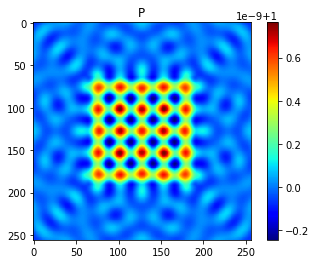

In [12]:
import time
import scipy.sparse.linalg as spla
import inspect

max_iter = 1000
C=np.empty(max_iter)
def report(xk):
    global i
    global C
    frame = inspect.currentframe().f_back
    C[i] = frame.f_locals['resid']
    i+=1


def my_gmres(A, b, x0, maxiter, tol):
    global i
    global toler
    global C
    gmres = []
#    A = np.asarray(A) 
#     if np.all(A == np.eye(A.shape[0], A.shape[1])):
#         return b
#     if np.all(A == np.diag(np.diagonal(A))):
#         return b/np.diagonal(M)
    t = time.time()
    U_gm =  spla.gmres(A, b,  x0=x0, maxiter = maxiter, tol = tol, callback = report)[0]   
    t = time.time() - t
    #plt.semilogy(np.arange(i)*1/i*t,C[:i]/np.linalg.norm(b), label="Generalized Minimal RESidual iterations")
    return C[:i]


A = spla.LinearOperator(shape = (size**2, size**2), matvec = lambda x: matvec(x,mask,k,e))
i = 0
b = get_plane_wave(1,k,size).reshape(-1,1)
x0 = np.zeros(size**2).reshape(-1,1)

gmres = my_gmres(A, b, x0, maxiter=max_iter, tol=6e-10)

vals = x.real.reshape(-1,size)
print(vals)
visualize(vals,"P")


# plt.semilogy(np.arange(gmres.shape[0]),gmres/np.linalg.norm(b), label="Generalized Minimal RESidual iterations")

# plt.legend()
# plt.title('Relative residual (depends on time) %i' % 256)
# plt.xlabel('Number of step')
# plt.ylabel('Relative residual norm')
# plt.show()

# i=0
# toler = 1e-6